# File reading:

In [3]:
import csv
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import spacy
import time
import pickle
import re
import glob
import json
import matplotlib.pyplot as plt

nlp = spacy.load("en_core_web_lg")

def samplestring_to_num(sampleoutput):
    """Takes a list (sample, output) where sample is "Positive", "Negative", "Neutral",
    or "Irrelevant", and returns the same list, but the aforementioned terms are
    replaced with 1, -1, 0, or None
    """
    match sampleoutput[0]:
        case "Positive":
            return [0, sampleoutput[1]]
        case "Negative":
            return [1, sampleoutput[1]]
        case "Neutral":
            return [2, sampleoutput[1]]
        case "Irrelevant":
            return None

def format_data(input_data):
    """Takes unformated data from training/validation, and formats it into a list

    Input: input_data -- a string, represeting one line from twitter_training/validation
    """
    row = next(csv.reader([input_data]))[2:]
    if len(row) != 2:
        return None
    return samplestring_to_num(row)
    
def create_data(data_csv, max_samples=None):
    """Create data formatted for training and validation
    
    Inputs:
    data_csv -- a string, directory of a csv of training/validation data
    max_samples -- int, how many samples to include, default is all (useful for debugging)
    
    Output: (samples, outputs) samples -- a list of vectorized data, outputs -- the model output given
    the vectorized data
    """
    with open(data_csv, 'r') as infile:
        training = infile.read().split("\n")[:max_samples]
        formatted = [format_data(data) for data in training]
        formatted = [line for line in formatted if line is not None]
        (outputs, samples) = ([], [])
        for data in formatted:
            if data == None:
                continue
            tokens = [token.vector for token in nlp(data[1].lower()) if not token.is_space]
            if len(tokens) == 0:
                continue    
            outputs.append(data[0])
            samples.append(tokens)

    return (samples, outputs)

def create_model(training_data, output_location, input_size = 300, hidden_size = 64, num_layers = 2, num_outputs = 3,\
                 epochs = 96, batch_size = 32, preexisting_model = None, max_samples = None):
    """Creates a model and saves it to a file

    Inputs:
    training_data -- a string, directory of a csv of training data
    output_location -- a string, directory of where model is saved
    max_samples -- int, how many samples to include, default is all (useful for debugging)
    """
    if training_data.split(".")[-1] not in ["csv", "csv/"]:
        raise TypeError("training_data should be a csv file.")
   
    (samples, outputs) = create_data(training_data, max_samples)

    tensor_samples = [torch.tensor(sample, dtype=torch.float32) for sample in samples]
    dataset = list(zip(tensor_samples, outputs))
    dataloader = DataLoader(dataset, batch_size, shuffle=True, collate_fn=collate_fn)
    
    sampleslen = len(samples)
    if preexisting_model == None:
        model = BiRNN(input_size, hidden_size, num_layers, num_outputs)
    else:
        with open(preexisting_model, 'rb') as infile:
            model = pickle.load(infile)
    
    model = train(model, dataloader, epochs, sampleslen, "cpu")
    
    print(format(f"Writing to {output_location}..."))
    with open(output_location, 'wb') as outfile:
        pickle.dump(model, outfile)
    print("Model created successfully!")

# Model:

In [4]:
class BiRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 2, num_outputs= 3):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_outputs = num_outputs
        self.bidirectional = True
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, bidirectional = True, dropout=0.3)
        self.fc1 = nn.Linear(hidden_size * 2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc_out = nn.Linear(64, num_outputs)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, padded_sequences, lengths):
        packed = pack_padded_sequence(padded_sequences, lengths, batch_first=True)
        output, hidden = self.rnn(packed)
        output, dummy = pad_packed_sequence(output, batch_first=True)
        final_output = output[torch.arange(output.size(0)), lengths - 1]

        out = self.relu(self.fc1(final_output))
        out = self.dropout(out)
        out = self.relu(self.fc2(out))
        out = self.dropout(out)
        return self.fc_out(out)
        
model = BiRNN(input_size=300, hidden_size=48, num_layers=2, num_outputs=3)

def collate_fn(batch):
    samples, labels = zip(*batch)
    lengths = torch.tensor([len(sample) for sample in samples])
    samples_padded = pad_sequence(samples, batch_first=True)
    lengths, perm_idx = lengths.sort(descending=True)
    samples_padded = samples_padded[perm_idx]
    labels = torch.tensor(labels)[perm_idx]
    return samples_padded, lengths, labels

def train(model, dataloader, epochs, samples, device):
    loss_func = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    
    for epoch in range(epochs):
        overallloss = 0 
        for sampleid, (padded_batch, lengths, labels) in enumerate(dataloader):
            if sampleid == 0 and epoch == 0:
                timea = time.time()
            optimizer.zero_grad()
            model_output = model(padded_batch, lengths)
            loss = loss_func(model_output, labels)
            overallloss += loss.item() * labels.size(0)
            loss.backward()
            optimizer.step()
            if sampleid == 10 and epoch == 0:
                overalltime = time.time() - timea
                print(format(f"ETA: {(overalltime * (len(dataloader)/10)) * epochs} seconds"))
        if epoch % 5 == 0:
            print(format(f"Epoch {epoch}: Loss = {overallloss/samples}"))

    return model

In [356]:
create_model("archive/twitter_training.csv", "models/twittermodel144epochs.model", preexisting_model="models/twittermodel9.model", epochs = 48)

ETA: 1886.536033630371 seconds
Epoch 0: Loss = 0.3456712493533747
Epoch 5: Loss = 0.33707948032315627
Epoch 10: Loss = 0.31879661679815235
Epoch 15: Loss = 0.3136616826862823
Epoch 20: Loss = 0.3013422507175108
Epoch 25: Loss = 0.2908162287408661
Epoch 30: Loss = 0.29530965123704456
Epoch 35: Loss = 0.27078714738059173
Epoch 40: Loss = 0.2665974939253795
Epoch 45: Loss = 0.2630106642600872
Writing to models/twittermodel144epochs.model...
Model created successfully!


# Model Validation & Testing:

In [7]:
def validate_model(model, validation_samples, max_samples=None):
    with open(model, 'rb') as infile:
        model = pickle.load(infile)
    
    loss = nn.CrossEntropyLoss()
    overallloss = 0
    acc = 0
    (samples, outputs) = create_data(validation_samples, max_samples)
    for (sample, output) in zip(samples, outputs):
        out = torch.tensor(sample, dtype=torch.float32).unsqueeze(0)
        modeloutput = model(out, torch.tensor([out.size(1)]))
        pred = torch.argmax(modeloutput, dim=1).item()
        if pred == output:
            acc += 1
    return acc/len(samples)   

def test(sample, model):
    sample = [token.vector for token in nlp(sample.lower()) if not token.is_space]
    tensor_sample = torch.tensor(sample, dtype=torch.float32).unsqueeze(0)
    modeloutput = model(tensor_sample, torch.tensor([tensor_sample.size(1)]))
    match torch.argmax(modeloutput, dim=1).item():
        case 0:
            return 1
        case 1:
            return 0
        case 2:
            return 0.5

# Evaluating Wikipedia Articles:

In [185]:
def get_sections(txt_file):
    """Takes in a specially formatted txt file
    containing a wikipedia article, and returns
    the text from each section
    """
    sections = dict()
    with open(txt_file, 'r') as infile:
        sections_list = infile.read().split("_____")

    topics = [section.split("\n")[0] for section in sections_list if section.split() != ""]

    for topic_id, topic in enumerate(topics):
        sections[topic] = sections_list[topic_id][len(topic):]
    
    if "External links" in sections.keys():
        del sections["External links"]
    
    return sections

def cleanup_section(text):
    """Takes an unformatted section of text,
    and cleans it up, removing any bracketed numbers
    and newlines
    """
    chars = "/()\"'$*"
    text = re.sub(r"\[(.*?)\]", "", text)
    for char in chars:
        text = text.replace(char, "")
    text = text.replace("\n", " ")
    text = text.strip()
    return text
    
def get_averages(txt_file, model):
    outputs = dict()
    sections = get_sections(txt_file)

    for section in sections.items():
        cleaned = cleanup_section(section[1])
        if cleaned == "":
            continue
        
        outputs[section[0]] = [test(sample, model) for sample in cleanup_section(section[1]).split(".") if sample.replace(" ", "") != ""]
        outputs[section[0]] = sum(outputs[section[0]])/len(outputs[section[0]])

    return outputs

with open("models/twittermodel144epochs.model", 'rb') as infile:
        model = pickle.load(infile)
    
def average_folder(folder, output_file, model):
    files = glob.glob(folder + "*.txt")
    output = dict()
    for file in files:
        output[file.split("/")[-1]] = get_averages(file, model)

    with open(output_file, "w") as outfile:
        json.dump(output, outfile)
        outfile.close()

average_folder("wikipedia articles/dave grohl/", "wikipedia articles/dave grohl.json", model)

In [146]:
with open("wikipedia articles/charli xcx.json", 'r') as infile:
    charlixcx = json.load(infile)

with open("wikipedia articles/apples.json", 'r') as infile:
    apples = json.load(infile)

with open("wikipedia articles/dave grohl.json", 'r') as infile:
    davegrohl = json.load(infile)

In [142]:
def getentries(articledata):
    entries = list(articledata.keys())
    entries.sort()
    return entries


def makegraph(articledata, section):
    entries = getentries(articledata)
    ypoints = np.array([articledata[entry][section] for entry in entries])
    xpoints = np.array([num for num in range(len(entries))])
    xpoints = np.array(entries)
    plt.ylim(0, 1)
    plt.plot(xpoints, ypoints, label=section)
    plt.xticks(size=6)
    

def makeallgraphs(articledata):
    entries = getentries(articledata)
    
    possiblekeys = list(articledata[list(articledata.keys())[0]].keys())
    for entry in articledata.keys():
        for possiblekeyid, possiblekey in enumerate(possiblekeys):
            if possiblekey not in articledata[entry]:
                del possiblekeys[possiblekeyid]

    for key in possiblekeys:
        makegraph(articledata, key)
    
    plt.legend(fontsize=8)

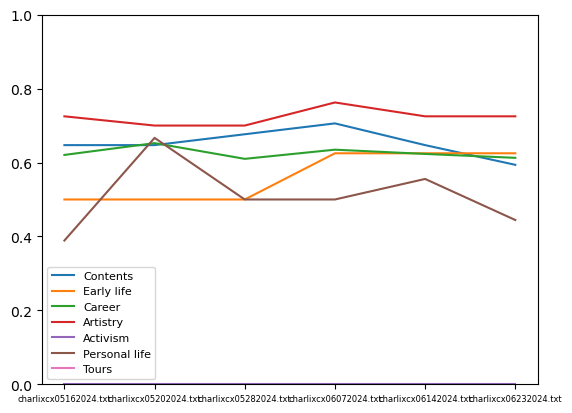

In [150]:
makeallgraphs(charlixcx)